In [638]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

from petro_utils import compare_pred_results

import seaborn as sns

import warnings # supress warnings
warnings.filterwarnings('ignore')

# Predicting Production with Machine Learning
The core of Petro.ai's machine learning pipeline are multivariate models that predict production based on geologic and engineering features of wells from a region of interest.  This notebook walks through a simplified workflow for building one of these models.  Your task is to run the simplified model, and understand the steps and the generated results.  You can use this as a start to improve the model, and demonstrate your experience and data science skills.

If need any clarification or have questions, feel free to reach out to Brendon at <brendon.hall@petro.ai>.

## Data
Petro.ai provides a download of well stats.  These are properties and attributes of the wells in the database.  These can be used as features to train predictive models. Well Stats contains one row per well with 100+ columns.  Don't worry, we won't use them all!

Here is a brief description of some of the columns in well stats that we might consider for modeling.
 * `totalDrainage` - predicted drainage area for a well (using Petro.ai drainage model)
 * `prodOil12mo` - cumulative 12 month oil production
 * `avgHzDistAnyZone` - average distance to nearby wells
 * `latitude`, `longitude` - surface location of well head
 * `angleFromSHMax` - angle between well azimuth and maximum horizontal stress direction


Well stats contains a raw download of all the wells in the collection.  There might be missing data, and we can transform these features before training a model.

As a first step, let's read the file `data/part2/well_stats_delaware.csv` into a pandas dataframe.

In [639]:
# read the well stats data, save to a pandas dataframe
df = pd.read_csv('../data/part2/well_stats.csv') # answer

# print the number of rows and columns in this dataframe.
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the raw well stats file.")

There are 2457 rows and 172 columns in the raw well stats file.


Let's rename the `totalDrainage` column to `drainage_area` to be more clear.

In [640]:
# rename the 'totalDrainage' column to 'drainage_area'
df.rename(columns={'totalDrainage':'drainage_area'}, inplace=True)

## Data Exploration
For an initial model we'll start with a few features from well stats described above:

- drainage area
- totalProppantByPerfLength
- avgHzDistAnyZone
- latitude
- longitude
- angleFromSHMax

There are many more we can try, but this will get us started.  For the first model,
let's try and predict 12 month cumulative oil production `prodOil12mo` directly.

First, plot the distribution of these features with respect to the `prodOil12mo` target.

In [641]:
#feature_names = ['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone', 'latitude', 'longitude', 'angleFromSHMax', 'lateralLength']
#target = 'prodOil12mo'

#g = sns.pairplot(df, x_vars=feature_names, y_vars=target, hue='interval')
#plt.show()

Did you notice any significant trends in these features?  Any outliers or potential issues? There are a number of wells with zero drainage, we'll filter those out.

Feel free to experiment with other types of plots, features, etc.

**[Debug Question]** In the next cell, we want to find the 12 mo. cumulative oil production for a specific well with `wellAPI` = 4200000036.  There is a bug in this code though.  Can you fix it to output the correct production amount?

In [642]:
#well_production = df[df['wellAPI'] == "4200000036"]["prodOil12mo"].values[0]
well_production = df.query('wellAPI == 4200000036')["prodOil12mo"].item()
print("The production of the well with API 4200000036 is:", well_production)

The production of the well with API 4200000036 is: 227347.0


In [643]:
df_model = df[['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone', 'latitude', 'longitude', 'angleFromSHMax', 'lateralLength', 'prodOil12mo']]
df_model.isna().sum()

drainage_area                  0
totalProppantByPerfLength    525
avgHzDistAnyZone               0
latitude                       0
longitude                      0
angleFromSHMax                 0
lateralLength                  6
prodOil12mo                  154
dtype: int64

In [644]:
df_model.corr()

,drainage_area,totalProppantByPerfLength,avgHzDistAnyZone,latitude,longitude,angleFromSHMax,lateralLength,prodOil12mo
drainage_area,1.000000,-0.079115,0.204507,0.056612,-0.048259,0.020854,-0.091635,0.108534
totalProppantByPerfLength,-0.079115,1.000000,-0.297495,-0.164460,-0.199341,-0.061656,0.385214,0.335033
avgHzDistAnyZone,0.204507,-0.297495,1.000000,0.154756,-0.014669,-0.010518,-0.383163,-0.218147
latitude,0.056612,-0.164460,0.154756,1.000000,-0.450329,-0.105174,-0.218155,-0.185327
longitude,-0.048259,-0.199341,-0.014669,-0.450329,1.000000,0.110571,-0.036311,-0.045839
angleFromSHMax,0.020854,-0.061656,-0.010518,-0.105174,0.110571,1.000000,-0.051407,-0.031307
lateralLength,-0.091635,0.385214,-0.383163,-0.218155,-0.036311,-0.051407,1.000000,0.588168
prodOil12mo,0.108534,0.335033,-0.218147,-0.185327,-0.045839,-0.031307,0.588168,1.000000


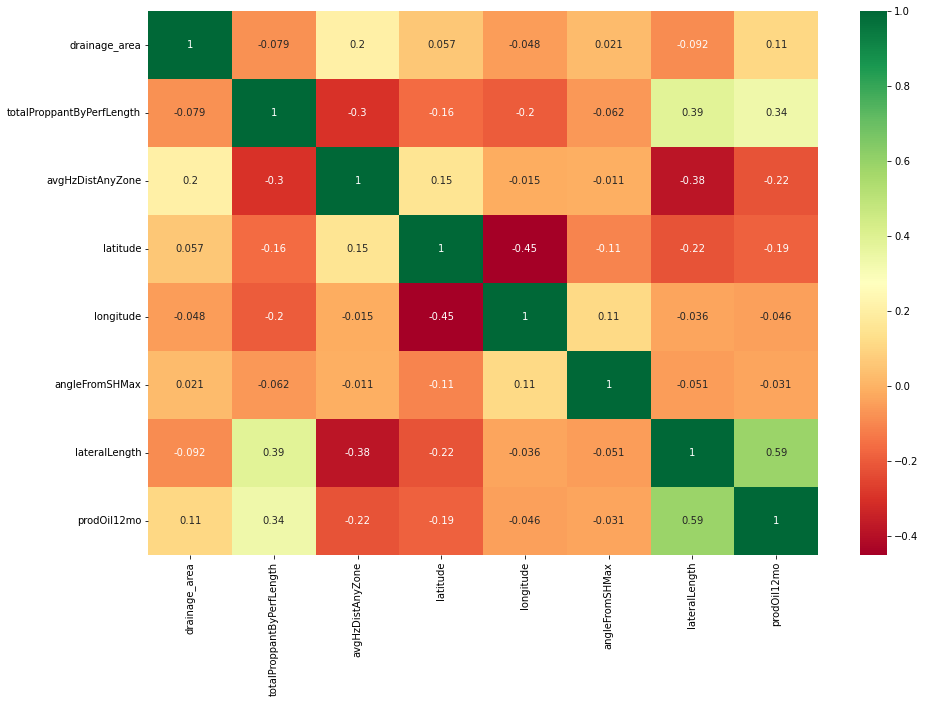

In [645]:
corrmat = df_model.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (15,10))

g = sns.heatmap(df_model[top_corr_features].corr(), annot= True, cmap='RdYlGn')

In [646]:
print(df_model.shape)
df_model

(2457, 8)


,drainage_area,totalProppantByPerfLength,avgHzDistAnyZone,latitude,longitude,angleFromSHMax,lateralLength,prodOil12mo
0,194838.58,2054.4040,1230.63430,36.389086,-113.386406,119,9247.0,132413.0000
1,344069.84,NaN,1350.47670,36.390055,-113.292040,121,9326.0,334629.0000
2,346702.40,1445.6741,2500.00000,36.371887,-113.457380,118,9163.0,185974.0000
3,343703.38,NaN,2500.00000,36.765614,-113.568970,133,NaN,18689.0000
4,346629.38,2625.1914,1311.51060,36.378030,-113.521040,59,6713.0,NaN
...,...,...,...,...,...,...,...,...
2452,0.00,NaN,2500.00000,36.599530,-113.329620,131,3433.0,46537.2700
2453,343003.80,NaN,1850.67350,36.436480,-113.250910,90,2168.0,104259.6950
2454,288406.78,2002.8323,936.39014,36.450010,-113.243910,91,9540.0,99119.4100
2455,346098.22,NaN,2496.40060,36.629090,-113.323060,55,NaN,7870.9844


## Data Filtering

Remove any wells with zero drainage_area from the dataset.

In [647]:
# Remove wells with zero drainage area
df_model = df_model[df_model['drainage_area'] > 0]

Now remove any wells that are missing data for any of the features or target from the dataset.  How many wells are left in the dataset?

In [648]:
# Remove wells missing features or production
df_model = df_model.dropna(inplace=False)
print(f"There are {df_model.shape[0]} rows in the cleaned well stats file.")

There are 1798 rows in the cleaned well stats file.


In [649]:
#df_model

In [650]:
print(df_model.columns)

Index(['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone',
       'latitude', 'longitude', 'angleFromSHMax', 'lateralLength',
       'prodOil12mo'],
      dtype='object')


In [651]:
features = df_model[['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone','latitude','longitude','angleFromSHMax','lateralLength']]
target = df_model[['prodOil12mo']]

In [652]:
import statsmodels.formula.api as smf
model = smf.ols(formula='prodOil12mo ~ drainage_area + totalProppantByPerfLength + avgHzDistAnyZone + angleFromSHMax + lateralLength + latitude + longitude', data = df_model)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            prodOil12mo   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     160.9
Date:                Tue, 02 Aug 2022   Prob (F-statistic):          1.24e-184
Time:                        07:22:58   Log-Likelihood:                -22371.
No. Observations:                1798   AIC:                         4.476e+04
Df Residuals:                    1790   BIC:                         4.480e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [653]:
# import statsmodels.formula.api as smf
# model = smf.ols(formula='prodOil12mo ~ drainage_area + totalProppantByPerfLength + avgHzDistAnyZone + angleFromSHMax + lateralLength', data = df_model)
# results = model.fit()
# print(results.summary())

# Transforming the Data

In [654]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scale = pd.DataFrame(scaler.fit_transform(features), columns = ['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone','latitude', 'longitude', 'angleFromSHMax', 'lateralLength'])
y_scale = pd.DataFrame(scaler.fit_transform(target), columns = ['prodOil12mo'])
#df_scaled = scaler.transform(df_model)
print(x_scale.shape)
print(y_scale.shape)

(1798, 7)
(1798, 1)


## Prepare Training Data

Now the dataset is ready to train a model.  Extract the features, $X$, and the "target" to be predicted, $y$, from the dataframe.  For now, we'll randomly select a third of the wells and set them aside to test the accuracy of the model.  We'll use the remainder as training data.

In [655]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x_scale, y_scale, test_size=0.30, random_state=42)

In [656]:
X_train_inv = scaler.inverse_transform(X_train)

In [657]:
X_train_inv = pd.DataFrame(X_train_inv, columns =['drainage_area', 'totalProppantByPerfLength', 'avgHzDistAnyZone','latitude','longitude','angleFromSHMax','lateralLength'])
X_train_inv

,drainage_area,totalProppantByPerfLength,avgHzDistAnyZone,latitude,longitude,angleFromSHMax,lateralLength
0,283500.657302,38508.696285,365199.007239,102267.928431,285109.063408,140158.105263,192827.393374
1,216012.729843,69043.299557,235913.709162,94837.866379,276192.420768,137074.947368,286446.171467
2,294740.880956,11485.074830,470056.000000,175504.165212,312221.858768,223403.368421,51619.069752
3,297943.387881,83788.435434,92590.583816,129426.302721,179893.999775,180239.157895,291127.110371
4,270506.865028,82812.355922,332776.484566,193737.677372,167121.065886,303565.473684,68236.402863
...,...,...,...,...,...,...,...
1253,283903.156282,43859.093559,200742.590717,325711.397214,230451.330555,328230.736842,84073.579491
1254,145360.423066,15046.210545,240319.161103,100929.154276,294728.349364,143241.263158,214983.837523
1255,241666.293350,64639.400724,215022.637906,361599.152880,66048.628900,408392.842105,295456.978858
1256,324424.678624,49906.808250,390772.537309,292685.013503,317127.826557,106243.368421,288435.570501


In [658]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (1258, 7) (1258, 1)
Test (540, 7) (540, 1)


## Train Random Linear Regression

Let's start simple. We'll build a simple random forest model and take a look at the prediction accuracy. 

In [659]:
from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# lr.fit(X_train,y_train)

In [660]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 10))}]

# step-3: perform grid search
# 3.1 specify model
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
rfe = RFE(lr2)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
    param_grid = hyper_params, 
    scoring= 'r2', 
    cv = folds, 
    verbose = 1,
    return_train_score=True)

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
             return_train_score=True, scoring='r2', verbose=1)

In [661]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007779,0.001934,0.002194,3.994704e-04,1,{'n_features_to_select': 1},0.351510,0.066171,0.345328,0.115756,...,0.229835,0.117974,9,0.342424,0.142937,0.344183,0.129715,0.362712,0.264394,0.104892
1,0.007579,0.001738,0.002992,6.312791e-04,2,{'n_features_to_select': 2},0.369775,0.374827,0.382569,0.365017,...,0.355774,0.035032,8,0.358409,0.356270,0.354453,0.359770,0.379386,0.361658,0.009048
2,0.005580,0.001355,0.002393,7.981779e-04,3,{'n_features_to_select': 3},0.398531,0.411278,0.385996,0.430233,...,0.396485,0.024819,7,0.401847,0.397919,0.403632,0.394703,0.412409,0.402102,0.006015
3,0.006781,0.000399,0.002992,2.780415e-07,4,{'n_features_to_select': 4},0.401053,0.411302,0.390371,0.428370,...,0.398453,0.022460,5,0.404492,0.399838,0.405691,0.398162,0.414466,0.404530,0.005703
4,0.004987,0.001411,0.002792,7.467736e-04,5,{'n_features_to_select': 5},0.402212,0.412238,0.383623,0.425190,...,0.397051,0.022175,6,0.404984,0.402009,0.407677,0.399467,0.415017,0.405831,0.005360
5,0.003402,0.001361,0.002194,3.993537e-04,6,{'n_features_to_select': 6},0.403226,0.414387,0.384661,0.424639,...,0.399027,0.020322,4,0.407910,0.404400,0.408754,0.402615,0.416460,0.408028,0.004777
6,0.004782,0.001718,0.003790,9.776030e-04,7,{'n_features_to_select': 7},0.404465,0.415844,0.389318,0.425786,...,0.400939,0.019946,1,0.408207,0.404620,0.409959,0.403041,0.416853,0.408536,0.004834
7,0.005186,0.000399,0.002793,3.986606e-04,8,{'n_features_to_select': 8},0.404465,0.415844,0.389318,0.425786,...,0.400939,0.019946,1,0.408207,0.404620,0.409959,0.403041,0.416853,0.408536,0.004834
8,0.004787,0.000746,0.003391,4.890257e-04,9,{'n_features_to_select': 9},0.404465,0.415844,0.389318,0.425786,...,0.400939,0.019946,1,0.408207,0.404620,0.409959,0.403041,0.416853,0.408536,0.004834


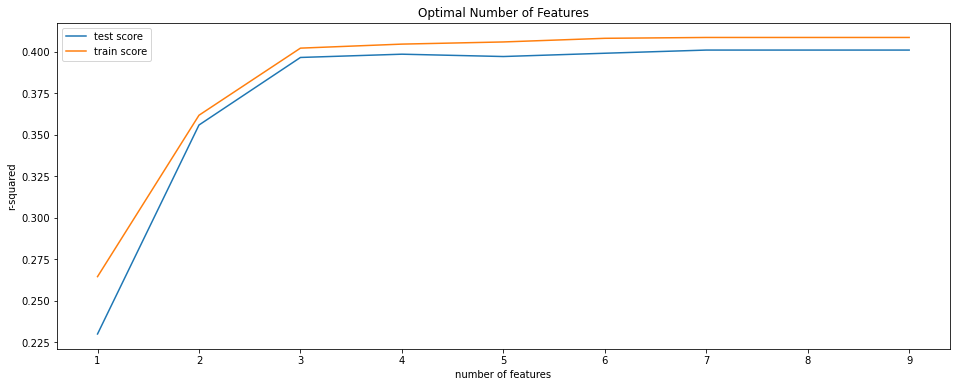

In [662]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [663]:
from sklearn.metrics import r2_score

# final model
n_features_optimal = 7

lr2 = LinearRegression()
lr2.fit(X_train, y_train)

rfe = RFE(lr, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lr2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

0.30509100276501677


In [664]:
# from sklearn.model_selection import cross_val_score, cross_val_predict
# from sklearn import metrics

# scores = cross_val_score(lr, X_train, y_train, cv = 5)

# print(scores, np.mean(scores), np.std(scores))

# predictions = cross_val_predict(lr, X_test, y_test, cv = 5)
# accuracy = metrics.r2_score(y_test, predictions)
# #print(predictions)
# print(accuracy)

## Model Evaluation
What is the $R^2$ score of this regression?  What is the error (or accuracy) of the result?

In [665]:
values = np.append(lr2.intercept_, lr2.coef_)
names = np.append('intercept', X_train.columns)
model_coefs = pd.DataFrame(values, index = names, columns=['coef_lr'])
print(model_coefs)

                            coef_lr
intercept                 -0.088141
drainage_area              0.290812
totalProppantByPerfLength  0.422572
avgHzDistAnyZone           0.018333
latitude                  -0.037160
longitude                 -0.041571
angleFromSHMax             0.039523
lateralLength              0.452835


In [666]:
#model_coefs.reset_index(drop=False,inplace=True)
#model_coefs = model_coefs.set_axis(['variables','coef_lr'], axis = 1, inplace=False)
#print(model_coefs)

In [667]:
print(lr2.score(X_test, y_test))
print(lr2.score(X_train, y_train))

0.30509100276501677
0.40780871641451877


In [668]:
y_pred = lr2.predict(X_test)
print(y_pred.shape)
print(y_test.shape)

(540, 1)
(540, 1)


In [669]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
#y_pred = lr.predict(X_test)
#y_test

In [670]:
from sklearn.metrics import r2_score
test_set_r2 = r2_score(y_test, y_pred)
print('Testing rˆ2:',round(test_set_r2,2))

Testing rˆ2: 0.31


In [671]:
y_test
print(y_test.shape)

(540, 1)


In [672]:
y_train = scaler.inverse_transform(y_train)
y_train_pred = lr2.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

Text(0.5, 1.0, 'Actual Vs. Predicted, Testing Data Set (30% of the data)')

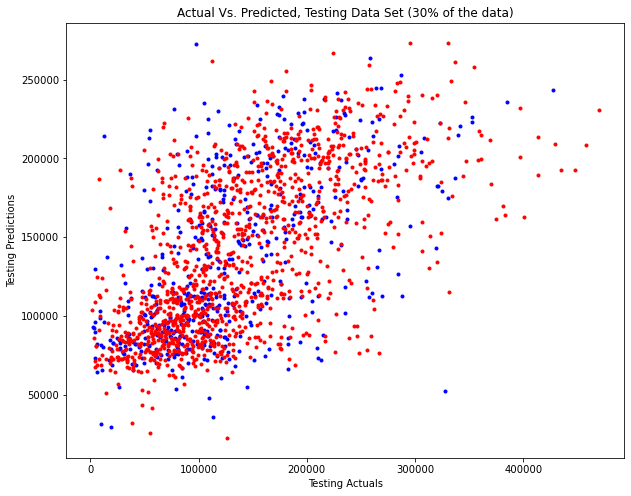

In [673]:
plt.figure(figsize = (10,8))
plt.plot(y_test ,y_pred, 'b.')
plt.plot(y_train,y_train_pred, 'r.')
plt.xlabel('Testing Actuals')
plt.ylabel('Testing Predictions')
plt.title('Actual Vs. Predicted, Testing Data Set (30% of the data)')

Use the utility `compare_pred_results` function to plot the predicted vs. actual production.

In [674]:
print(y_train.shape)
print(y_train_pred.shape)

(1258, 1)
(1258, 1)


In [675]:
# mean_absolute_percentage_error(y_test, y_test_pred)
r2 = r2_score(y_train, y_train_pred)
acc =  1- mean_absolute_percentage_error(y_train, y_train_pred)
print(f"Train data: the r2 score is {r2:.3f}, the accuracy is {acc:.3f}")

r2 = r2_score(y_test, y_pred)
acc =  1- mean_absolute_percentage_error(y_test, y_pred)
print(f"Test data: the r2 score is {r2:.3f}, the accuracy is {acc:.3f}")

Train data: the r2 score is 0.408, the accuracy is 0.300
Test data: the r2 score is 0.305, the accuracy is 0.076


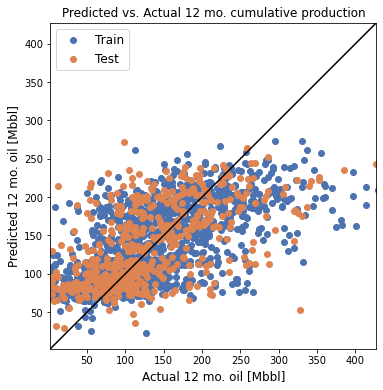

In [676]:
compare_pred_results(y_train, y_train_pred, y_test, y_pred, scale_factor=1e3, title="Predicted vs. Actual 12 mo. cumulative production",
                     xlabel="Actual 12 mo. oil [Mbbl]", ylabel="Predicted 12 mo. oil [Mbbl]")

## Lasso Regression

The first type of regularization technique is called __LASSO__, which stands for least absolute shrinkage and selection operator. It is also known as regression with L1 regularization. We will fit the same model as we did in our linear regression.

In [677]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=42)

In [678]:
lasso = Lasso(normalize=True, random_state=42, alpha=0.0001).fit(X_train,y_train)

In [679]:
values = np.append(lasso.intercept_, lasso.coef_)
names = np.append('intercept', X_train.columns)
coefs_lasso = pd.DataFrame(values, index = names, columns=['coef_lasso'])

model_coefs = model_coefs.join(coefs_lasso)
print(model_coefs)

                            coef_lr    coef_lasso
intercept                 -0.088141 -2.015436e+06
drainage_area              0.290812  3.244943e-01
totalProppantByPerfLength  0.422572  1.157312e+01
avgHzDistAnyZone           0.018333  3.444194e+00
latitude                  -0.037160 -3.332096e+04
longitude                 -0.041571 -2.742681e+04
angleFromSHMax             0.039523  1.218548e+02
lateralLength              0.452835  1.766410e+01


In [680]:
print(lasso.score(X_test,y_test))
print(lasso.score(X_train,y_train))

0.3050910420484674
0.4078087164145022


## Ridge Regression

Now let’s look at another regularization technique, __ridge regression__. It is also known as regression with L2 regularization.
Most of the code will be very similar to that seen with the previous methods. We will fit the model on our training data, and combine the results with our ongoing dataframe of results. 

In [681]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# list of alpha to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 1.0, 5.0, 10, 50, 100]}
ridge = Ridge()
folds = 5

# Defining GridSearchCV
grid_cv_model = GridSearchCV(estimator=ridge,
    param_grid=params,
    scoring='neg_mean_absolute_error',
    cv=folds,
    return_train_score=True,
    verbose=1)

# fiting GridSearchCV() with X_train and y_train
grid_cv_model.fit(X_train,y_train)

# Saving GridSearchCV results into a dataframe 
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

# filter cv_results with all param_alpha less than or equal to 200
cv_results = cv_results[cv_results['param_alpha']<=200]

# cv_results head
cv_results.head()
grid_cv_model.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'alpha': 0.0001}

In [682]:
ridge = Ridge(normalize=True, random_state=0.0001, alpha=0.0001).fit(X_train, y_train)

In [683]:
values = np.append(ridge.intercept_, ridge.coef_)
names = np.append('intercept', X_train.columns)
coefs_ridge = pd.DataFrame(values, index = names, columns=['coef_ridge'])

model_coefs = model_coefs.join(coefs_ridge)
print(model_coefs)

                            coef_lr    coef_lasso    coef_ridge
intercept                 -0.088141 -2.015436e+06 -2.015241e+06
drainage_area              0.290812  3.244943e-01  3.244511e-01
totalProppantByPerfLength  0.422572  1.157312e+01  1.157349e+01
avgHzDistAnyZone           0.018333  3.444194e+00  3.441530e+00
latitude                  -0.037160 -3.332096e+04 -3.332365e+04
longitude                 -0.041571 -2.742681e+04 -2.742628e+04
angleFromSHMax             0.039523  1.218548e+02  1.218268e+02
lateralLength              0.452835  1.766410e+01  1.766184e+01


In [684]:
print(ridge.score(X_test,y_test))
print(ridge.score(X_train,y_train))

0.305109825652077
0.40780871179822464


## Elastic Net

The elastic net is a regularization technique that combines the ridge and LASSO regression techniques.

In [685]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(random_state=42).fit(X_train, y_train)

values = np.append(en.intercept_, en.coef_)
names = np.append('intercept', X_train.columns)
coefs_en = pd.DataFrame(values, index = names, columns=['coef_en'])

model_coefs = model_coefs.join(coefs_en)
model_coefs

,coef_lr,coef_lasso,coef_ridge,coef_en
intercept,-0.088141,-2.015436e+06,-2.015241e+06,-163062.558361
drainage_area,0.290812,3.244943e-01,3.244511e-01,0.327291
totalProppantByPerfLength,0.422572,1.157312e+01,1.157349e+01,13.301231
avgHzDistAnyZone,0.018333,3.444194e+00,3.441530e+00,3.668453
latitude,-0.037160,-3.332096e+04,-3.332365e+04,-689.218991
longitude,-0.041571,-2.742681e+04,-2.742628e+04,-549.853688
angleFromSHMax,0.039523,1.218548e+02,1.218268e+02,128.041487
lateralLength,0.452835,1.766410e+01,1.766184e+01,17.888885


In [686]:
print(en.score(X_test,y_test))
print(en.score(X_train,y_train))

0.2996352237291321
0.4048721602656299
